In [1]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions_hamming import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 16
PAYLOADSIZE_DEC = 12

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE_DEC-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Removing "|" after packet size

In [ ]:
f = open("log_old.txt", 'r')
fn = open("log.txt", 'a+')
fn.seek(0)
lines = f.readlines()
for line in lines:
    if line[18] == '|':
        fn.write(line[0:17])
        fn.write(line[19:])
    else:
        fn.write(line)
fn.close()
f.close()

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp_rx }|\text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }|\text{rssi}}$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [2]:
# define the file name
filename = "54-42-2m-isch_ham"
# import file to jupyter notebook
df = readfile("./" + filename + ".txt")
# check the imported data first 10 lines
df.head(10)

,index,time_rx,rssi,seq,payload
0,0,2023-05-11 10:20:57.436,-92,0,07 80 02 d0 08 49 7a 9e 0b 5e 07 06 38 08 6e 92
1,1,2023-05-11 10:20:57.499,-90,1,07 83 45 56 22 ca f5 20 09 0c c3 62 36 88 1b 32
2,2,2023-05-11 10:20:57.548,-92,2,07 85 85 3a 06 c9 30 5a 07 f2 e3 4c 29 08 cb b0
3,3,2023-05-11 10:20:57.612,-92,3,07 86 c2 bc 14 87 09 f2 0a 9a 06 00 30 88 1d 68
4,4,2023-05-11 10:20:57.675,-93,4,07 8a 07 2e 1e 88 e8 2a 08 19 62 d8 39 47 93 ec
5,5,2023-05-11 10:20:57.722,-92,5,07 8c 45 30 2f 46 15 40 0c 99 a3 ae 1d 09 e4 a4
6,6,2023-05-11 10:20:57.786,-95,6,07 8f 83 c8 2f 8a 73 4e 04 ec e3 6c 30 87 c9 4c
7,7,2023-05-11 10:20:57.849,-95,7,07 91 c4 ca 22 09 81 fe 07 01 c4 32 13 89 bc 14
8,8,2023-05-11 10:20:57.896,-93,8,07 94 04 68 22 09 c0 7c 09 ca 82 d8 37 cd 5d 02
9,9,2023-05-11 10:20:57.961,-91,9,07 97 45 70 3b 04 16 ea 07 5b 45 24 01 08 f8 a4


In [3]:
# delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
df.reset_index(inplace=True)

In [4]:
# replace the resettable seq number to unresettable, for the purpose of reliability calculation
test = replace_seq(df.copy(), MAX_SEQ=256)
test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [5]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:00:25.991000, which is 25.991 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ sent}$$
***
**Interesting to look at**:
1. *Expected number of transmission*: the ratio of the number of packets correctly received by the data sink and the number of packets sent by the source.

$$ETX = \frac{Number\ of\ packet\ received}{Number\ of\ packet\ sent}$$

2. *Packet reliability*: the number of packet bit correctly delivered to next hop.

## Statistics

In [6]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber, error, file_content = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
bit_reliability = (1-ber)*100
print(f"Bit reliability [%]: {bit_reliability}")

The total number of packets transmitted by the tag is 447.
                                               data
0        [19, 93, 31, 67, 27, 69, 37, 111, 33, 254]
10      [15, 126, 32, 107, 43, 176, 36, 75, 38, 85]
20        [26, 86, 34, 232, 20, 32, 31, 48, 37, 25]
30     [26, 20, 35, 168, 35, 140, 25, 226, 23, 194]
40        [37, 78, 31, 76, 39, 164, 49, 191, 28, 8]
...                                             ...
40910  [34, 112, 28, 234, 30, 45, 29, 210, 30, 143]
40920    [39, 234, 29, 43, 34, 80, 34, 149, 33, 85]
40930    [43, 13, 35, 206, 23, 218, 28, 96, 29, 48]
40940    [26, 88, 31, 201, 35, 146, 24, 32, 44, 40]
40950  [33, 216, 26, 183, 36, 56, 42, 234, 30, 250]

[4096 rows x 1 columns]
seq 0: [0x1e, 0x0, 0x1c, 0x21, 0x23, 0xd9, 0x2d, 0x78, 0x30, 0xe0, 0x23, 0x78]
should be: [0x1c, 0x21, 0x23, 0xd9, 0x2d, 0x78, 0x30, 0xe0, 0x23, 0x78]
seq 1: [0x1e, 0xa, 0x24, 0x8b, 0x2f, 0xa2, 0x24, 0x36, 0x16, 0xda, 0x20, 0xd2]
should be: [0x24, 0x8b, 0x2f, 0xa2, 0x24, 0x36, 0x16, 0xda, 0x

In [7]:
# payload example for debug purpose
# correct sequence for pesudoseq NO. '0000'
tmp = file_content.loc[int('0000', base=16), 'data']
for i in tmp:
    print("{:02x}".format(i), end=" ")

13 5d 1f 43 1b 45 25 6f 21 fe 

Text(0.5, 0, 'Seq. Number')

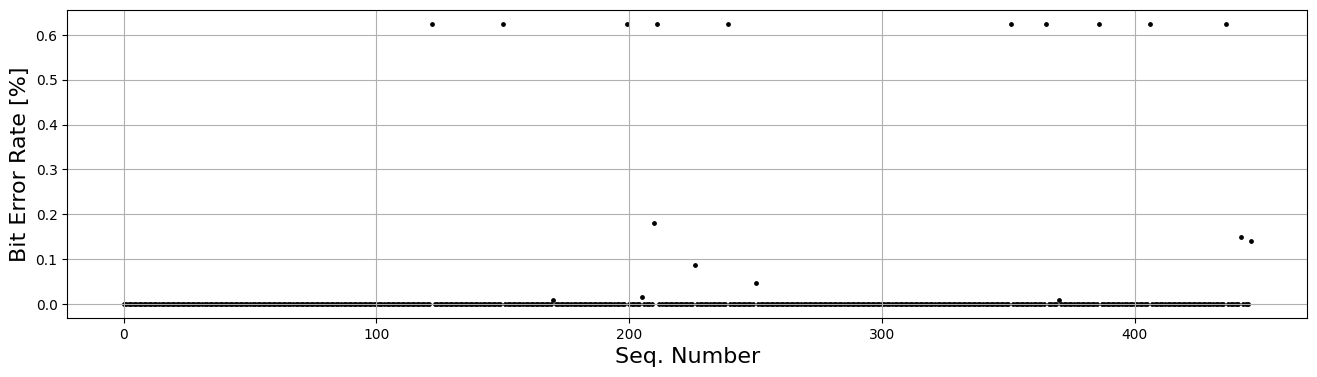

In [8]:
# BER for each packet
plt.scatter(error.seq, error.bit_error/(PAYLOADSIZE*8), marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%]', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [9]:
# record the distance
dis_carrier_tag = 0.15
dis_tag_rx = 0.04

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 3.6e-05


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

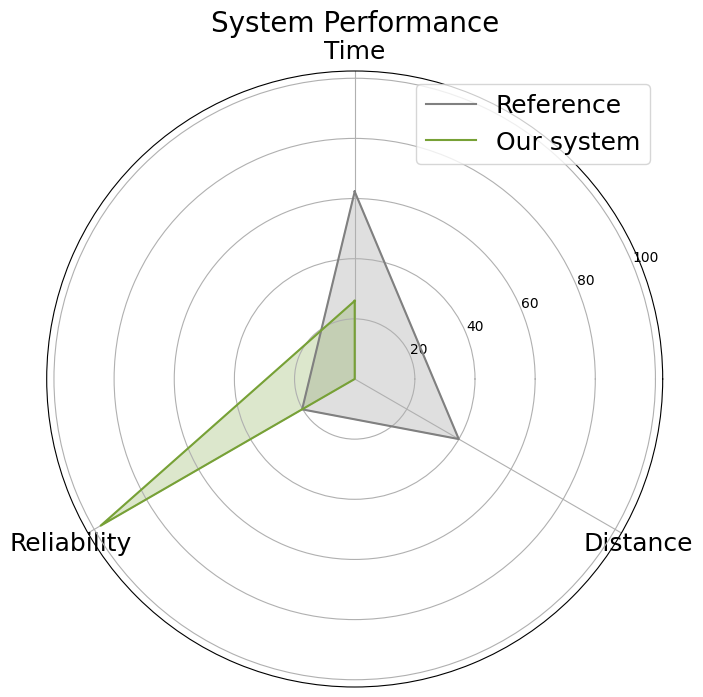

In [10]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)